# Guide on how to use the backtester

In [3]:
# Ensure the project root is in PATH.
import sys
sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.backtester import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing

import numpy as np
import pandas as pd
import sys
import os

This is the implementation of our trader

In [4]:
def size_function(z, edge_0, edge_max, max_position = 50):
    z = np.array(z)
    direction = np.where(z > 0, -1, 1)
    abs_z = np.abs(z)
    size = np.where(
        abs_z <= edge_0,
        0,
        np.where(
            abs_z >= edge_max,
            max_position,
            max_position * ((abs_z - edge_0) / (edge_max - edge_0)) ** 2
        )
    )
    return direction * size

def exit_size_function(z, edge_0, edge_max, max_position = 50):
    # Positive quadratic function with points (0, 0) and (-2, 50)
    if z <= 0:
        if z >= -edge_0:
            return 0
        elif z <= -edge_max:
            return max_position
            
        a = -max_position/(edge_max - edge_0)**2
        return a * (z + edge_max)**2 + max_position
    else:
        if z <= edge_0:
            return 0
        elif z >= edge_max:
            return -max_position
        a = max_position/(edge_max - edge_0)**2
        return a * (z-edge_max)**2 - max_position


In [36]:


class Trader:
    
    def run(self, state: TradingState):
        # Only method required. It takes all buy and sell orders for all symbols as an input, and outputs a list of orders to be sent
        print("traderData: " + state.traderData)
        print("Observations: " + str(state.observations))
        result = {}
        synthetic_offer = 0    # What I can buy at
        synthetic_bid = 0
        best_ask = 0
        best_bid = 0
        best_ask_jam = 0
        best_bid_jam = 0
        best_bid_croissant = 0
        best_ask_croissant = 0
        available_sell = 0
        available_buy = 0
        print(state.position)
        
        for product in state.order_depths:
            order_depth: OrderDepth = state.order_depths[product]
            orders: List[Order] = []
            # Basket 2 is 4 croissants, 2 jams
            if product == "CROISSANTS":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_croissant, best_ask_amount_croissant = list(order_depth.sell_orders.items())[0]
                    best_bid_croissant, best_bid_amount_croissant = list(order_depth.buy_orders.items())[0]
                    synthetic_bid += best_bid_croissant * 4
                    synthetic_offer += best_ask_croissant * 4

            if product == "JAMS":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_jam, best_ask_amount_jam = list(order_depth.sell_orders.items())[0]
                    best_bid_jam, best_bid_amount_jam = list(order_depth.buy_orders.items())[0]
                    synthetic_bid += best_bid_jam * 2
                    synthetic_offer += best_ask_jam * 2

            if product == 'PICNIC_BASKET2':
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask, best_ask_amount = list(order_depth.sell_orders.items())[0]
                    best_bid, best_bid_amount = list(order_depth.buy_orders.items())[0]

        if abs((best_ask + best_bid)/2 - (synthetic_offer + synthetic_bid)/2) < 50:
            min_spread = 4

            if best_ask - best_bid > min_spread:     #Spreads are at least 3 wide so we can improve both by 1 and not hack. We then quote 2 lots
                orders.append(Order('PICNIC_BASKET2', best_bid+1, 1))
                orders.append(Order('PICNIC_BASKET2', best_ask-1, -1))

        result['PICNIC_BASKET2'] = orders
        print(orders)

           
                
    
    
        traderData = "SAMPLE" # String value holding Trader state data required. It will be delivered as TradingState.traderData on next execution.
        
        conversions = 1
        return result, conversions, traderData


Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [37]:
market_data_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_-1.csv"), sep=";")
market_data_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_0.csv"), sep=";")
market_data_day_neg2 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_1.csv"), sep=";")

trades_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_-1.csv"), sep=";")
trades_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_0.csv"), sep=";")
trades_day_neg2 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_1.csv"), sep=";")


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

market_data_all3days = concatenate_historical_data([market_data_day_neg2, market_data_day_neg1, market_data_day_0])
trades_all3days = concatenate_historical_data([trades_day_neg2, trades_day_neg1, trades_day_0])

In [38]:
market_data_round_2_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_-1.csv"), sep=";")
market_data_round_2_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_0.csv"), sep=";")
market_data_round_2_day_1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_1.csv"), sep=";")

trades_round_2_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_-1.csv"), sep=";")
trades_round_2_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_0.csv"), sep=";")
trades_round_2_day_1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_1.csv"), sep=";")


market_data_round_2_all3days = concatenate_historical_data([market_data_round_2_day_neg1, market_data_round_2_day_0, market_data_round_2_day_1])
trades_round_2_all3days = concatenate_historical_data([trades_round_2_day_neg1, trades_round_2_day_0, trades_round_2_day_1])

Lets run the backtester

In [39]:
# 1. Define the listings.
listings = {
    "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    "JAMS": Listing(symbol="JAMS", product="JAMS", denomination="SEASHELLS"),
    "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
    "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS")
}

# 2. Define the position limits.
position_limit = {
    "KELP": 50,
    "RAINFOREST_RESIN": 50,
    "SQUID_INK": 50,
    "CROISSANTS": 250,
    "JAMS": 350,
    "DJEMBES": 60,
    "PICNIC_BASKET1": 60,
    "PICNIC_BASKET2": 100
    
}


# 3. Define fair value evaluation functions. This is used to determine what our PNL is at times throughout execution when our net position is not 0.
def calc_rainforest_resin_fair(order_depth: OrderDepth) -> float:
    return 10000


fair_value_evaluator = {
    # omitting dictionary entries for KELP, SQUID_INK, so that they use default behaviour: fair_price = (best_bid+best_ask)/2
    "RAINFOREST_RESIN": calc_rainforest_resin_fair,
}


# 4. Market data and trade history files.
# These already exist, look at the previous jupyter cell.

# 5. Instantiate trader object
trader = Trader()
bt = Backtester(trader, listings, position_limit, fair_value_evaluator, market_data_round_2_day_neg1, trades_round_2_day_neg1, output_log_filename="steven.log")


bt.run()

print(bt.pnl)

traderData: 
Observations: None
{'KELP': 0, 'RAINFOREST_RESIN': 0, 'SQUID_INK': 0, 'CROISSANTS': 0, 'DJEMBES': 0, 'JAMS': 0, 'PICNIC_BASKET1': 0, 'PICNIC_BASKET2': 0}
[]
traderData: SAMPLE
Observations: None
{'KELP': 0, 'RAINFOREST_RESIN': 0, 'SQUID_INK': 0, 'CROISSANTS': 0, 'DJEMBES': 0, 'JAMS': 0, 'PICNIC_BASKET1': 0, 'PICNIC_BASKET2': 0}
[]
traderData: SAMPLE
Observations: None
{'KELP': 0, 'RAINFOREST_RESIN': 0, 'SQUID_INK': 0, 'CROISSANTS': 0, 'DJEMBES': 0, 'JAMS': 0, 'PICNIC_BASKET1': 0, 'PICNIC_BASKET2': 0}
[]
traderData: SAMPLE
Observations: None
{'KELP': 0, 'RAINFOREST_RESIN': 0, 'SQUID_INK': 0, 'CROISSANTS': 0, 'DJEMBES': 0, 'JAMS': 0, 'PICNIC_BASKET1': 0, 'PICNIC_BASKET2': 0}
[]
traderData: SAMPLE
Observations: None
{'KELP': 0, 'RAINFOREST_RESIN': 0, 'SQUID_INK': 0, 'CROISSANTS': 0, 'DJEMBES': 0, 'JAMS': 0, 'PICNIC_BASKET1': 0, 'PICNIC_BASKET2': 0}
[]
traderData: SAMPLE
Observations: None
{'KELP': 0, 'RAINFOREST_RESIN': 0, 'SQUID_INK': 0, 'CROISSANTS': 0, 'DJEMBES': 0, 'JAMS'

PNL: {'KELP': 0.0, 'RAINFOREST_RESIN': 0, 'SQUID_INK': 0.0, 'CROISSANTS': 0.0, 'DJEMBES': 0.0, 'JAMS': 0.0, 'PICNIC_BASKET1': 0.0, 'PICNIC_BASKET2': -5212.5}
Midpoint Sharpe: -0.1339
Spreadcrossing Sharpe: -0.1446
Midpoint PnL (bps): -0.06
Spreadcrossing PnL (bps): -0.06


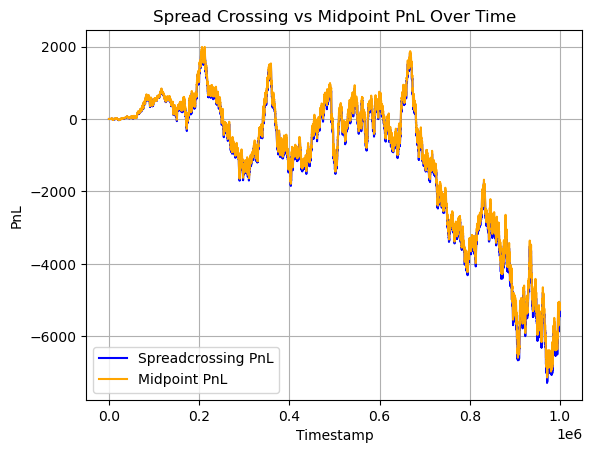

In [40]:
import matplotlib.pyplot as plt    
product = "PICNIC_BASKET2"

resin_metrics = bt.calculate_metrics(product)
print(f"PNL: {bt.pnl}")

print(f"Midpoint Sharpe: {resin_metrics['midpoint_sharpe']:.4f}")
print(f"Spreadcrossing Sharpe: {resin_metrics['spreadcrossing_sharpe']:.4f}")
print(f"Midpoint PnL (bps): {resin_metrics['midpoint_pnl_bps']:.2f}")
print(f"Spreadcrossing PnL (bps): {resin_metrics['spreadcrossing_pnl_bps']:.2f}")

# THIS PART PLOTS SPREADCROSSING_PNL AND MIDPOINT_PNL
spreadcrossing_pnl_history = bt.get_metric("spreadcrossing_pnl", product)
midpoint_pnl_history = bt.get_metric("midpoint_pnl", product)
timestamps = np.unique(bt.market_data["timestamp"])

plt.plot(timestamps, spreadcrossing_pnl_history, label="Spreadcrossing PnL", color="blue")
plt.plot(timestamps, midpoint_pnl_history, label="Midpoint PnL", color="orange")
plt.xlabel("Timestamp")
plt.ylabel("PnL")
plt.title("Spread Crossing vs Midpoint PnL Over Time")
plt.legend()
plt.grid(True)
plt.show()


You can copy paste everything, except for the Trader algo, which should be whatever algo you wish to backtest.

In [30]:
edge_0 = 70
edge_max = 150

edge_max_retreet = 100
edge_0_retreet = 0

position_max = int(250/4)

In [331]:
pos_sell = exit_size_function(95, edge_0_retreet, edge_max_retreet, position_max)
pos_sell

-61.845

In [332]:
size_function(133, edge_0, edge_max, position_max)

-38.449687499999996